In [2]:
# Import the libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

import prepare

### Loading the datasets

In [2]:
# Read csv files

df_features = pd.read_csv('train_features.csv', index_col=0)
df_targets = pd.read_csv('train_targets_scored.csv', index_col=0)

# Print the shapes
df_features.shape, df_targets.shape

((23814, 875), (23814, 206))

In [3]:
# Take a peek at features
df_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


**Plans for Preparation**
1. Remove controls in both features and targets to reduce the background noise. Since all the control has no labels, it is easy to predict. 
2. Store the index.
3. Drop the categorical variables. 
4. Scale the continuous varibles by StandardScaler. 
5. Convert back to dataframe.

**Updated Plans for Preparation**
1. Remove controls in both features and targets to reduce the background noise.
2. Drop the categorical variablesin features.
3. Concat the features and targets based on index.
4. Split to train/validate/test.
5. Store the indexes.
6. Scaled the train/validate/test by StandardScaler.
7. Conver back to dataframe.

### Prepare the features for dimentionality reduction

#### 1. Remove the controls

In [4]:
# Create a mask for the treated
mask_trt = (df_features.cp_type == 'trt_cp')

# Cout the number of the treated
mask_trt.sum()

21948

In [5]:
# Remove the controls in features
df_features_trt = df_features[mask_trt]

# Print the shape of the new dataframe
df_features_trt.shape

(21948, 875)

In [6]:
# Remove the controls in targets
df_targets_trt = df_targets[mask_trt]

# Print the shape of the new targets df
df_targets_trt.shape

(21948, 206)

In [7]:
# Check if the index in both dataframes match
(df_features_trt.index == df_targets_trt.index).sum()

21948

#### 2. Drop the categoricals

In [8]:
# Count the unique values in df_features_trt
df_features_trt.cp_type.value_counts() # Double check

trt_cp    21948
Name: cp_type, dtype: int64

In [9]:
# Drop the categricals
df_features_trt.drop(columns=['cp_type', 'cp_time', 'cp_dose'], inplace=True)

# Print the shape
df_features_trt.shape

(21948, 872)

#### 3. Concat the features and targets

In [10]:
# Concat the two dataframes
df_trt = pd.concat([df_features_trt, df_targets_trt], axis=1)

# Print the shape
print(df_trt.shape)

# Take a peek at the df
df_trt.head()

(21948, 1078)


,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,0,0,0,0,0,0,0,0,0,0
id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,0,0,0,0,0,0,0,0,0,0
id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,0,0,0,0,0,0,0,0,0,0


#### 4. Split to train/validate/test

In [11]:
# Split by the helper function: random state=123
train, validate, test = prepare.split_my_data(df_trt)

# Print the shapes
train.shape, validate.shape, test.shape

((15802, 1078), (3951, 1078), (2195, 1078))

#### 5. Store the index

In [12]:
# Store the index of the datasets

id_train = train.index.to_list()
id_validate = validate.index.to_list()
id_test = test.index.to_list()

# Print the size of the lists
len(id_train), len(id_validate), len(id_test)

(15802, 3951, 2195)

#### 6. Scale the continuous

In [13]:
# Take a peek at train dataset
train.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,0.0720,0.5719,2.0570,-0.0573,-0.2205,0.5554,-0.0405,0.3739,-0.1357,-0.4667,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,-0.8073,-0.3968,-0.8006,0.6920,0.0296,-0.9625,1.1890,-0.2969,-0.5961,-0.1806,...,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,0.6550,-0.0741,0.0016,0.7568,-0.0687,-0.2326,-0.0660,-0.8257,0.7720,0.9261,...,0,0,0,0,0,0,0,0,0,0
id_d8f5ca938,-0.0169,-0.1208,2.5430,0.2975,1.7560,-0.1732,0.2754,0.1622,0.7210,0.1228,...,0,0,0,0,1,0,0,0,0,0
id_c4eaa645d,-0.0849,0.9049,-0.6745,-0.5889,0.6982,-1.0050,0.4392,0.8376,0.3309,-0.1561,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Seperate the features and targets

X_train = train.iloc[:, 0:872]
Y_train = train.iloc[:, 872:]

X_validate = validate.iloc[:, 0:872]
Y_validate = validate.iloc[:, 872:]

X_test = test.iloc[:, 0:872]
Y_test = test.iloc[:, 872:]

# Print the shapes
X_train.shape, Y_train.shape, X_validate.shape, Y_validate.shape, X_test.shape, Y_test.shape

((15802, 872),
 (15802, 206),
 (3951, 872),
 (3951, 206),
 (2195, 872),
 (2195, 206))

In [15]:
# Create the scaler

scaler = StandardScaler()
scaler

StandardScaler()

In [16]:
# Fit on train
scaler = scaler.fit(X_train)

# Transform the train/validate/test

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Print the data type of X_scaled
print(type(X_train_scaled))

# The length of the array should match the number of observations
print(len(X_train_scaled)) # 15802, matched

# The length of every member in the array shoulb math the number of the features
print(len(X_train_scaled[0])) # 872, matched

<class 'numpy.ndarray'>
15802
872


#### 7. Convert to dataframe

In [17]:
# Restore the index on train
X_train_scaled = pd.DataFrame(X_train_scaled, index=id_train)

# Print the shape 
X_train_scaled.shape

(15802, 872)

In [18]:
# Take a peek at the scaled features
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,862,863,864,865,866,867,868,869,870,871
id_887911684,-0.144982,0.812500,1.821725,-0.146696,-0.298498,0.588709,-0.061409,0.507947,0.056658,-0.520643,...,0.272481,0.479881,-0.174342,0.398723,0.444098,0.202342,0.442696,0.643210,0.512050,0.396295
id_294d38ce4,-0.757505,-0.394671,-0.935656,0.628157,-0.054680,-0.693410,1.348360,-0.079186,-0.197903,-0.259169,...,0.748601,0.246026,0.469820,0.488347,0.504859,0.044373,0.322610,0.339516,0.593659,0.646899
id_b12cf3d9c,0.261138,0.007470,-0.161590,0.695167,-0.150511,-0.076888,-0.090648,-0.542031,0.558538,0.752275,...,-0.135973,0.144500,0.474851,0.674763,-0.040190,0.192640,0.056071,-0.121075,0.518279,1.484066
id_d8f5ca938,-0.206910,-0.050726,2.290680,0.220204,1.628353,-0.026715,0.300808,0.322652,0.530339,0.018117,...,0.135847,0.608195,0.440265,-0.038179,0.295718,0.680773,0.467795,0.519973,0.673473,0.386119
id_c4eaa645d,-0.254279,1.227476,-0.813979,-0.696425,0.597125,-0.729308,0.488624,0.913812,0.314648,-0.236777,...,0.229689,-0.534862,0.104132,0.208216,0.212895,0.281148,0.594696,0.367388,0.864299,-0.059429


In [19]:
# The index of X and Y should be the same
(X_train_scaled.index == Y_train.index).sum()

15802

In [20]:
# Check the mean of for features
X_train_scaled.mean(axis=0)[:5] # Should be zero for all the features

0    2.156581e-17
1    6.829115e-18
2    2.728836e-17
3    6.850193e-19
4    1.436081e-17
dtype: float64

In [21]:
# Checkt the variance of the scaled dataset
X_train_scaled.var(axis=0)[:5] # Checked: should be 1 from begining to the end

0    1.000063
1    1.000063
2    1.000063
3    1.000063
4    1.000063
dtype: float64

In [22]:
# Restore the index on validate
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=id_validate)

# Print the shape 
X_validate_scaled.shape

# Compare the index of X and Y
(X_validate_scaled.index == Y_validate.index).sum() # matched

3951

In [23]:
# Restore the index on test
X_test_scaled = pd.DataFrame(X_test_scaled, index=id_test)

# Print the shape 
X_test_scaled.shape

# Compare the index of X and Y
(X_test_scaled.index == Y_test.index).sum() # matched

2195

In [38]:
# Take a peek at Y_train
Y_train.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_d8f5ca938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
id_c4eaa645d,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# # Save Y_train/validate/test as csv files

# Y_train.to_csv('Y_train.csv')
# Y_validate.to_csv('Y_validate.csv')
# Y_test.to_csv('Y_test.csv')

**Plans for Dimensionality Reduction**
1. Reduce the features by Kernel PCA-cosine to 50. 
2. Convert the transformed features back to df and store as csv
3. Reduce the features by Kernel PCA-rbf to 50. 
4. Convert the transformed features back to df and store as csv

### Dimensionality Reduction by Kernel PCA (Cosine)

In [24]:
# Create the PCA object
kpca_cos = KernelPCA(n_components=50, kernel='cosine')

# Print the object
kpca_cos

KernelPCA(kernel='cosine', n_components=50)

In [25]:
# Fit on train
kpca_cos = kpca_cos.fit(X_train_scaled) # Take 15 mins. 

# Print the object
kpca_cos

KernelPCA(kernel='cosine', n_components=50)

In [27]:
# Transform train/validate/test

X_train_cos = kpca_cos.transform(X_train_scaled)
X_validate_cos = kpca_cos.transform(X_validate_scaled)
X_test_cos = kpca_cos.transform(X_test_scaled)

# Print the shapes
X_train_cos.shape, X_validate_cos.shape, X_test_cos.shape

((15802, 50), (3951, 50), (2195, 50))

In [32]:
# Convert back to the dataframes

X_train_cos = pd.DataFrame(X_train_cos, index=id_train)
X_validate_cos = pd.DataFrame(X_validate_cos, index=id_validate)
X_test_cos = pd.DataFrame(X_test_cos, index=id_test)

# Print the shapes
X_train_cos.shape, X_validate_cos.shape, X_test_cos.shape

((15802, 50), (3951, 50), (2195, 50))

In [34]:
# Take a peek at X_train_cos
X_train_cos.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,-0.004725,-0.046098,-0.000499,0.032700,-0.090504,0.031419,-0.122123,0.024048,-0.122287,-0.012305
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,-0.023376,0.004647,0.002614,0.044699,0.061037,-0.002453,-0.014456,-0.020474,0.008282,0.037586
id_b12cf3d9c,-0.116704,-0.175076,-0.216695,0.093239,0.098658,-0.023396,-0.040551,-0.069963,0.081209,-0.049178,...,0.071413,-0.054937,0.077372,-0.072166,-0.020397,-0.001381,-0.006411,-0.014820,-0.020163,0.062042
id_d8f5ca938,-0.108337,0.198954,-0.001508,0.331887,-0.138065,-0.079667,-0.033503,-0.174493,-0.137442,0.065832,...,-0.014569,0.025528,0.022390,-0.048285,0.023898,0.037983,-0.026742,0.069053,0.004214,0.062170
id_c4eaa645d,0.113585,-0.318411,0.101633,-0.034343,0.128269,-0.208788,-0.105685,0.149461,-0.098587,0.329119,...,0.014009,-0.024623,0.016682,0.044054,0.003013,-0.019702,-0.029526,0.003733,-0.052697,0.008851


In [33]:
# # Save as csv files

# X_train_cos.to_csv('X_train_cos.csv')
# X_validate_cos.to_csv('X_validate_cos.csv')
# X_test_cos.to_csv('X_test_cos.csv')

### Dimensionality Reduction by Kernel PCA (rbf)

In [35]:
# Create the PCA object
kpca_rbf = KernelPCA(n_components=50, kernel='rbf')

# Print the object
kpca_rbf

KernelPCA(kernel='rbf', n_components=50)

In [36]:
# Fit on train
kpca_rbf = kpca_rbf.fit(X_train_scaled) 

# Print the object
kpca_rbf

KernelPCA(kernel='rbf', n_components=50)

In [37]:
# Transform train/validate/test

X_train_rbf = kpca_rbf.transform(X_train_scaled)
X_validate_rbf = kpca_rbf.transform(X_validate_scaled)
X_test_rbf = kpca_rbf.transform(X_test_scaled)

# Print the shapes
X_train_rbf.shape, X_validate_rbf.shape, X_test_rbf.shape

((15802, 50), (3951, 50), (2195, 50))

In [41]:
# Convert back to the dataframes

X_train_rbf = pd.DataFrame(X_train_rbf, index=id_train)
X_validate_rbf = pd.DataFrame(X_validate_rbf, index=id_validate)
X_test_rbf = pd.DataFrame(X_test_rbf, index=id_test)

# Print the shapes
X_train_rbf.shape, X_validate_rbf.shape, X_test_rbf.shape

((15802, 50), (3951, 50), (2195, 50))

In [42]:
# Take a peek at train_rbf
X_train_rbf.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
id_887911684,-0.113804,0.073874,-0.045844,-0.040177,0.001239,0.028486,0.008133,0.189038,0.009369,-0.035972,...,0.021074,0.019273,0.040316,-0.044190,0.035163,-0.068163,0.031149,-0.005280,-0.018714,0.040590
id_294d38ce4,-0.081761,0.238309,0.273610,0.066148,0.035802,0.028016,0.053274,0.117625,0.037382,-0.037918,...,0.010674,-0.008108,0.014344,-0.045436,-0.047832,-0.014416,-0.014711,-0.018614,-0.024334,-0.018353
id_b12cf3d9c,-0.042848,0.095801,-0.151614,0.068988,-0.043790,0.014354,-0.053366,-0.053073,-0.046212,0.059299,...,0.006034,-0.001349,0.000459,0.006673,0.086122,0.047384,0.031068,-0.020613,0.052809,0.019886
id_d8f5ca938,-0.095446,-0.102518,0.033974,0.220547,0.048482,-0.078481,0.082272,-0.107104,0.021217,-0.071515,...,-0.026697,-0.005765,-0.018127,-0.011354,0.033982,0.016215,-0.022585,0.028705,0.034875,0.014630
id_c4eaa645d,0.034598,0.148927,0.002449,-0.061712,-0.151287,-0.147584,0.114287,0.100925,-0.138400,-0.179451,...,0.025211,0.027269,-0.002506,0.001640,0.002665,-0.007431,-0.037124,-0.053390,0.005366,0.024452


In [43]:
# # Save as csv files

# X_train_rbf.to_csv('X_train_rbf.csv')
# X_validate_rbf.to_csv('X_validate_rbf.csv')
# X_test_rbf.to_csv('X_test_rbf.csv')

### Dimensionality Reduction by T-SNE

In [59]:
# Create the object
tsne = TSNE(n_components=50, random_state=123)

# Print the object
tsne

TSNE(n_components=50, random_state=123)

**Quick Notes**:
- Fit on X_train_cos or _rbf
    - ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.
- Fit on X_train_scaled: 
    - Same error. 
- In a word, t-SNE is used for visualiztion rather than dimentionality reduction. 

### Visualize train/validate/test_cos on labels nfkb and cyclooxygenase inhibitors

In [3]:
# Load train, validate and test

X_train_cos = pd.read_csv('X_train_cos.csv', index_col=0)
Y_train = pd.read_csv('Y_train.csv', index_col=0)

X_validate_cos = pd.read_csv('X_validate_cos.csv', index_col=0)
Y_validate = pd.read_csv('Y_validate.csv', index_col=0)

X_test_cos = pd.read_csv('X_test_cos.csv', index_col=0)
Y_test = pd.read_csv('Y_test.csv', index_col=0)


# Print their shapes
X_train_cos.shape, Y_train.shape, X_validate_cos.shape, Y_validate.shape, X_test_cos.shape, Y_test.shape

((15802, 50), (15802, 206), (3951, 50), (3951, 206), (2195, 50), (2195, 206))

In [4]:
# Create the labels of nfkb and cyclo

nfkb_train = Y_train.loc[:, 'nfkb_inhibitor']
cyclo_train = Y_train.loc[:, 'cyclooxygenase_inhibitor']

nfkb_validate = Y_validate.loc[:, 'nfkb_inhibitor']
cyclo_validate = Y_validate.loc[:, 'cyclooxygenase_inhibitor']

nfkb_test = Y_test.loc[:, 'nfkb_inhibitor']
cyclo_test = Y_test.loc[:, 'cyclooxygenase_inhibitor']

### Visualizing the train

In [6]:
# Prepare the data for visualizing the train

# Copy X_train_cos
df_train_cos = X_train_cos.copy()

# Concat the target columns
df_train_cos['nfkb'] = nfkb_train.values
df_train_cos['cyclo'] = cyclo_train.values

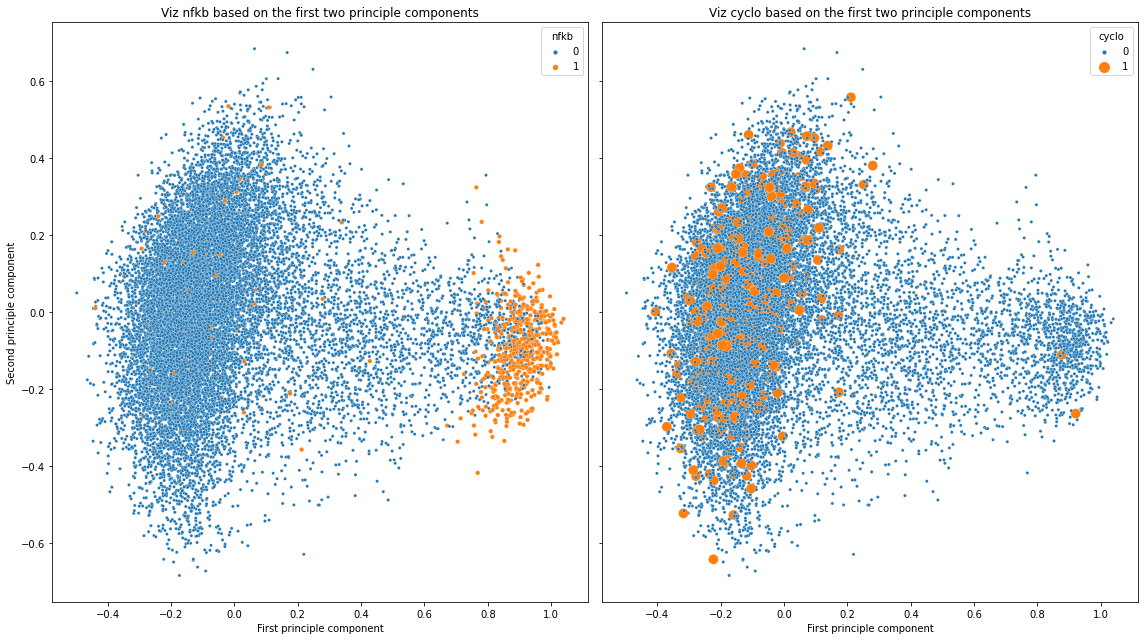

In [9]:
# Viz the train dataset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_train_cos, x=df_train_cos.iloc[:, 0], y=df_train_cos.iloc[:, 1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_train_cos, x=df_train_cos.iloc[:, 0], y=df_train_cos.iloc[:, 1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Visualizing on validate

In [10]:
# Prepare the data for visualizing the train

# Copy X_train_cos
df_validate_cos = X_validate_cos.copy()

# Concat the target columns
df_validate_cos['nfkb'] = nfkb_validate.values
df_validate_cos['cyclo'] = cyclo_validate.values

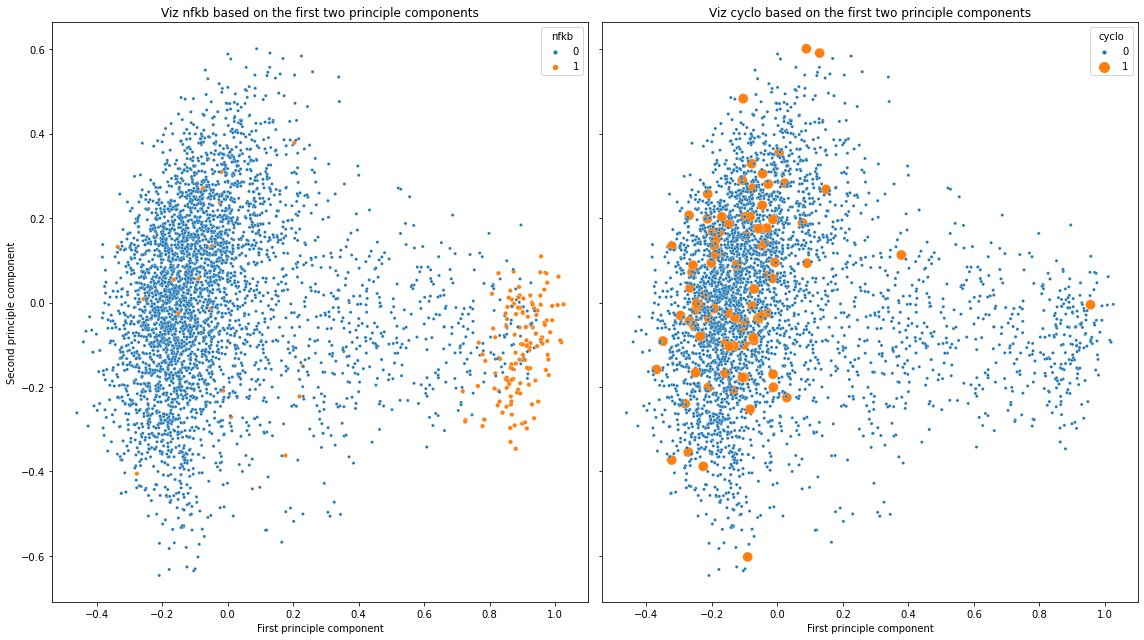

In [11]:
# Viz the validate dataset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_validate_cos, x=df_validate_cos.iloc[:, 0], y=df_validate_cos.iloc[:, 1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_validate_cos, x=df_validate_cos.iloc[:, 0], y=df_validate_cos.iloc[:, 1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Visualize on test

In [12]:
# Prepare the data for visualizing the train

# Copy X_train_cos
df_test_cos = X_test_cos.copy()

# Concat the target columns
df_test_cos['nfkb'] = nfkb_test.values
df_test_cos['cyclo'] = cyclo_test.values

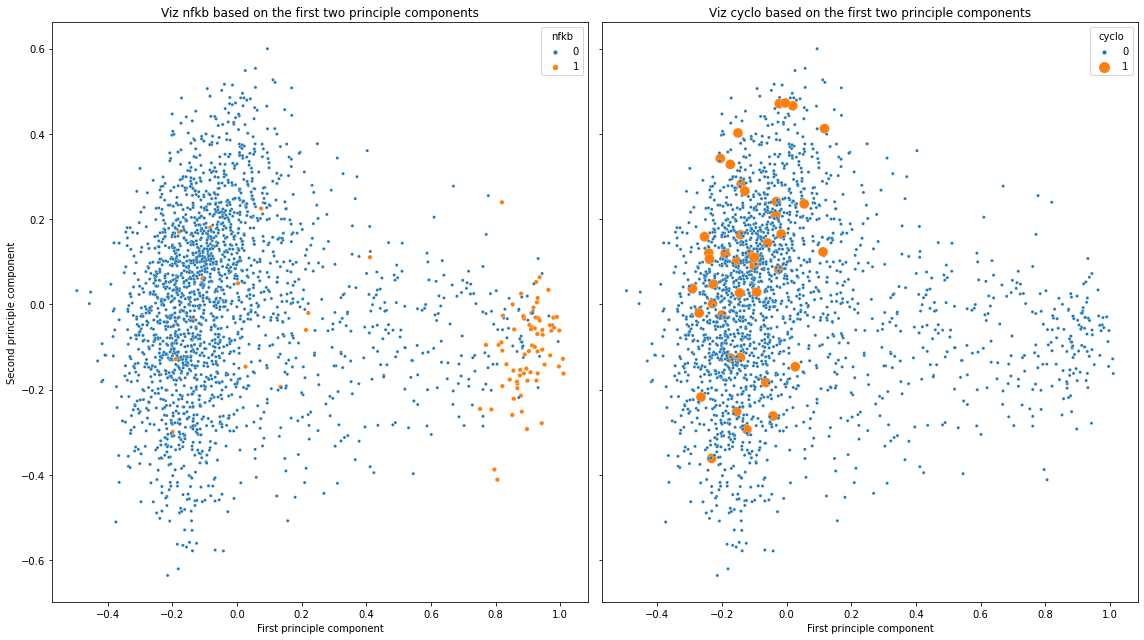

In [13]:
# Viz the test dataset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_test_cos, x=df_test_cos.iloc[:, 0], y=df_test_cos.iloc[:, 1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_test_cos, x=df_test_cos.iloc[:, 0], y=df_test_cos.iloc[:, 1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Visualize train/validate/test_rbf on labels nfkb and cyclooxygenase inhibitors

In [14]:
# Load train, validate and test

X_train_rbf = pd.read_csv('X_train_rbf.csv', index_col=0)
Y_train = pd.read_csv('Y_train.csv', index_col=0)

X_validate_rbf = pd.read_csv('X_validate_rbf.csv', index_col=0)
Y_validate = pd.read_csv('Y_validate.csv', index_col=0)

X_test_rbf = pd.read_csv('X_test_rbf.csv', index_col=0)
Y_test = pd.read_csv('Y_test.csv', index_col=0)


# Print their shapes
X_train_rbf.shape, Y_train.shape, X_validate_rbf.shape, Y_validate.shape, X_test_rbf.shape, Y_test.shape

((15802, 50), (15802, 206), (3951, 50), (3951, 206), (2195, 50), (2195, 206))

In [15]:
# Create the labels of nfkb and cyclo

nfkb_train = Y_train.loc[:, 'nfkb_inhibitor']
cyclo_train = Y_train.loc[:, 'cyclooxygenase_inhibitor']

nfkb_validate = Y_validate.loc[:, 'nfkb_inhibitor']
cyclo_validate = Y_validate.loc[:, 'cyclooxygenase_inhibitor']

nfkb_test = Y_test.loc[:, 'nfkb_inhibitor']
cyclo_test = Y_test.loc[:, 'cyclooxygenase_inhibitor']

### Visualize the train

In [16]:
# Prepare the data for visualizing the train

# Copy X_train_rbf
df_train_rbf = X_train_rbf.copy()

# Concat the target columns
df_train_rbf['nfkb'] = nfkb_train.values
df_train_rbf['cyclo'] = cyclo_train.values

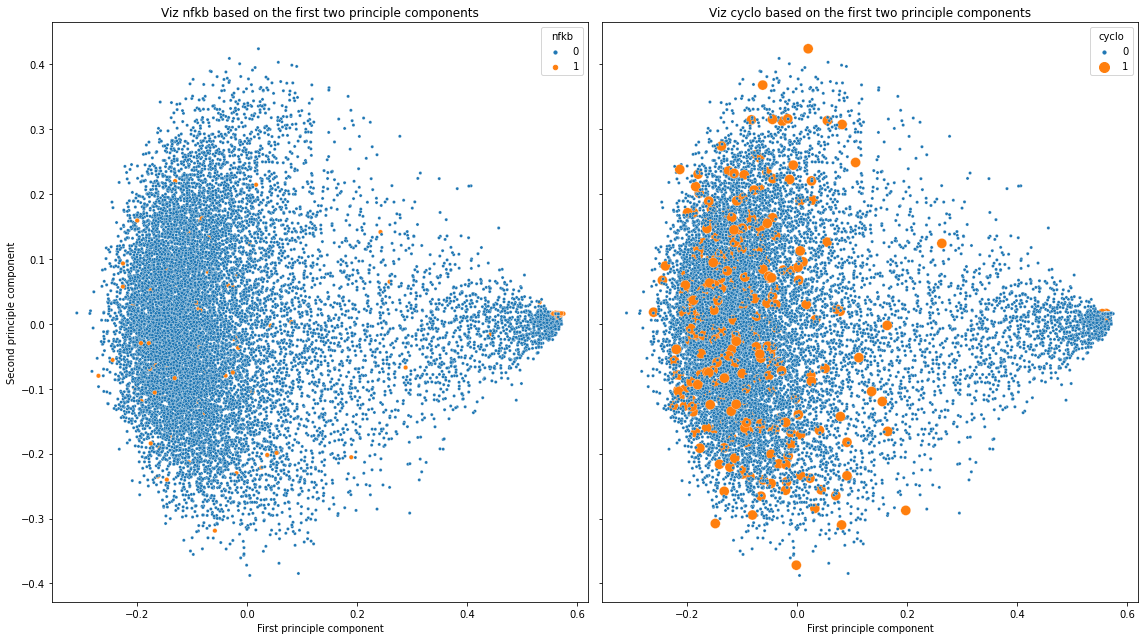

In [17]:
# Viz the train dataset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_train_rbf, x=df_train_rbf.iloc[:, 0], y=df_train_rbf.iloc[:, 1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_train_rbf, x=df_train_rbf.iloc[:, 0], y=df_train_rbf.iloc[:, 1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Visualizing the validate

In [18]:
# Prepare the data for visualizing the train

# Copy X_train_rbf
df_validate_rbf = X_validate_rbf.copy()

# Concat the target columns
df_validate_rbf['nfkb'] = nfkb_validate.values
df_validate_rbf['cyclo'] = cyclo_validate.values

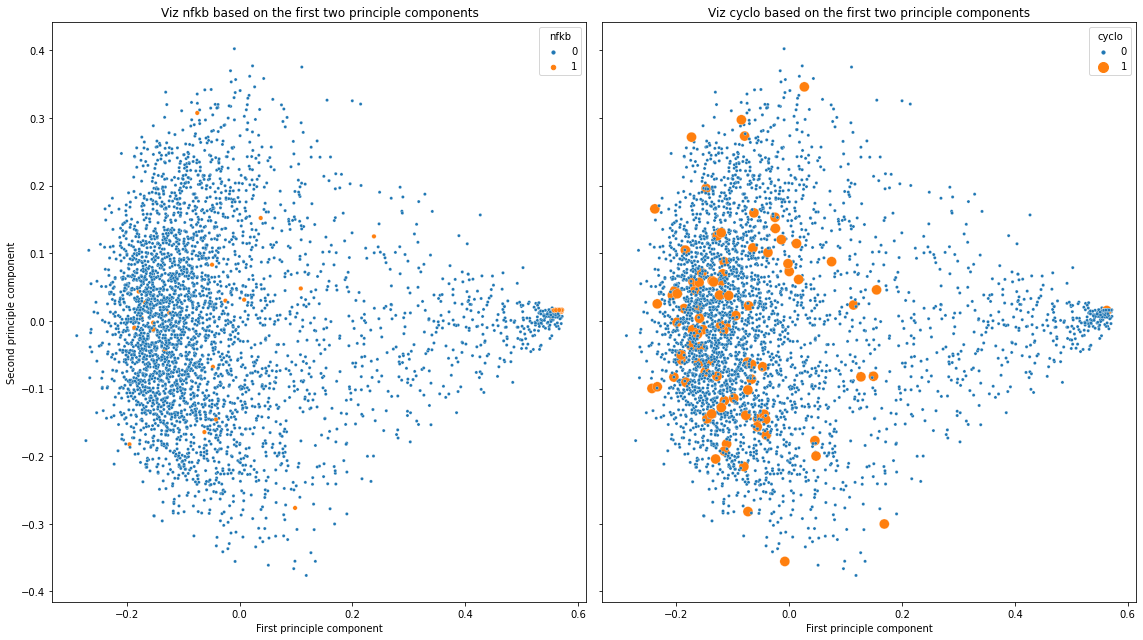

In [19]:
# Viz the validate dataset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_validate_rbf, x=df_validate_rbf.iloc[:, 0], y=df_validate_rbf.iloc[:, 1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_validate_rbf, x=df_validate_rbf.iloc[:, 0], y=df_validate_rbf.iloc[:, 1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()

### Visualizing the test

In [20]:
# Prepare the data for visualizing the train

# Copy X_train_rbf
df_test_rbf = X_test_rbf.copy()

# Concat the target columns
df_test_rbf['nfkb'] = nfkb_test.values
df_test_rbf['cyclo'] = cyclo_test.values

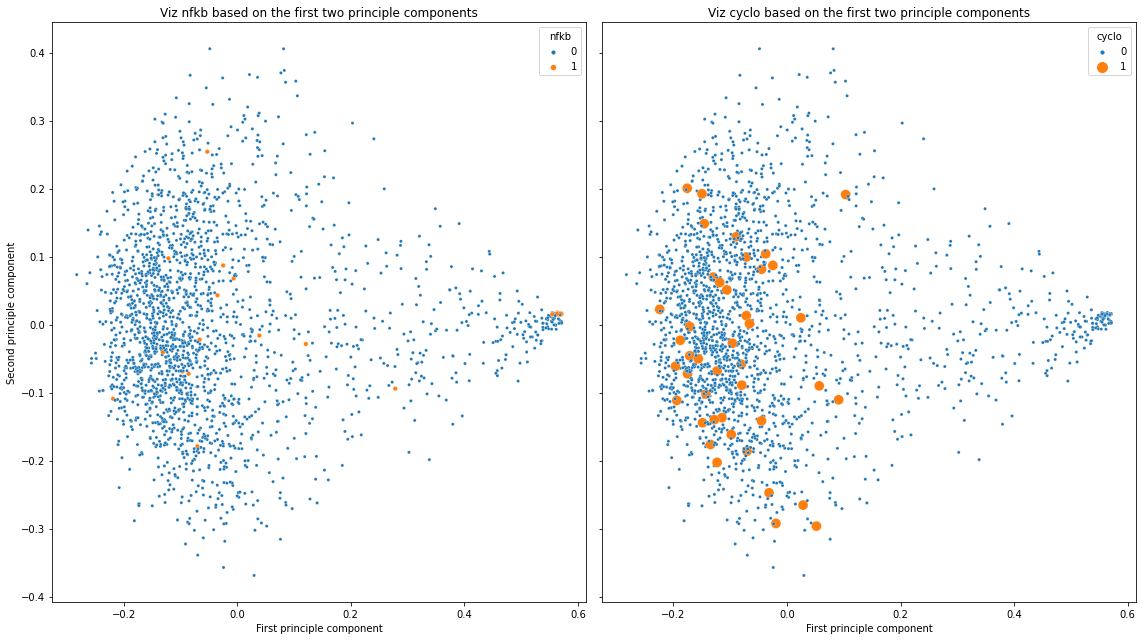

In [21]:
# Viz the test dataset

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), sharey=True)

sns.scatterplot(data=df_test_rbf, x=df_test_rbf.iloc[:, 0], y=df_test_rbf.iloc[:, 1], 
                hue='nfkb', size='nfkb', sizes=(20, 10), ax=ax1)
ax1.set_title('Viz nfkb based on the first two principle components')
ax1.set_xlabel('First principle component')
ax1.set_ylabel('Second principle component')

sns.scatterplot(data=df_test_rbf, x=df_test_rbf.iloc[:, 0], y=df_test_rbf.iloc[:, 1], 
                hue='cyclo', size='cyclo', sizes=(100, 10), ax=ax2)
ax2.set_title('Viz cyclo based on the first two principle components')
ax2.set_xlabel('First principle component')
ax2.set_ylabel('Second principle component')

plt.tight_layout()
plt.show()